# Data preprocessing

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import pprint as pp
import pickle
import os

Reads data from file and creates 2 dataframes. One with cell features (attributes) and second with expression values.

In [11]:
with open("sample_input.tab", "r") as file:
    att_dict = {}
    exp_dict = {}
    for line in file:
        if line.startswith("\t"):
            att = line.strip().split("\t")[0]
            vals = line.strip().split("\t")[1:]
            att_dict[att] = vals
        else:
            gene = line.strip().split("\t")[0]
            exp = line.strip().split("\t")[2:]
            exp_dict[gene] = exp
colData = pd.DataFrame(att_dict,index = att_dict["cell_id"])
countData = pd.DataFrame(exp_dict, index = att_dict["cell_id"])
countData = countData.astype(dtype=float, errors="raise")

Visualization of UMI (unique molecules) counts per sample before normalization.

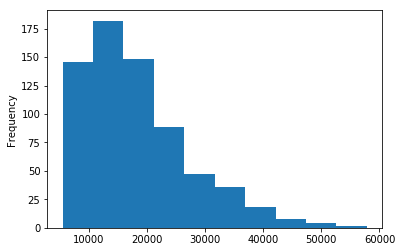

In [12]:
sample_sums = countData.sum(axis=1)
plt.figure
sample_sums.plot.hist()

Obtained data are raw data, meaning they are not normalized for sequencing depth (number of molecules per sequenced library) therefore samples (cells) are not comparable. Usuall aproach for this kind of normalization is "CPM" (counts per milion), when for each sample, scaling factor is calculated as a sum of molecules belonging to sample. Then each number of molecules belonging to sample is divided by sample specific scaling factor and multiplied by 1 milion. Furthermore, it is common to log-normalize expressional data (ln(x+1)) in order to get normal distribution.

Because those normalizations are sample (cell) specific, I included this data adjustment before splitting data into traning and validation sets. 

In [13]:
normalized_countData = countData.apply(lambda x: ((x / np.sum(x))*1000000), axis=1)
normalized_countData = normalized_countData.apply(lambda x: np.log1p(x))

Visualization of UMI (unique molecules) counts per sample after normalization.

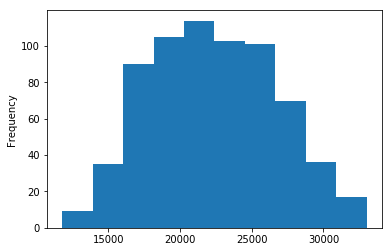

In [14]:
sample_sums = normalized_countData.sum(axis=1)
plt.figure
sample_sums.plot.hist()

Since the obtained dataset is not large, I account for cross validation I defined function for splitting datasets randomly into test and training sets (20 % : 80 %).

In [15]:
def splitter(dataframe, group_column_name):
    splitted = {}
    groups = dataframe[group_column_name].astype(dtype="category",errors="raise")
    groups = groups.cat.categories.tolist()
    for category in groups:
        group_df = dataframe[dataframe[group_column_name] == category]
        shape = group_df.shape
        _20_pc = round((shape[0] / 100)*20,0)
        _80_pc = shape[0] - _20_pc
        train_set = group_df.sample(int(_80_pc))
        test_set = group_df.sample(int(_20_pc))
        splitted[category] = {}
        splitted[category]["train_set"] = train_set
        splitted[category]["train_set"][group_column_name] = splitted[category]["train_set"][group_column_name].astype(dtype=int, errors="raise")
        splitted[category]["test_set"] = test_set
        splitted[category]["test_set"][group_column_name] = splitted[category]["test_set"][group_column_name].astype(dtype=int, errors="raise")
        
    train_data = pd.concat(splitted[category]["train_set"] for category in groups)
    test_data = pd.concat(splitted[category]["test_set"] for category in groups)
    return(train_data, test_data)

Splitting into training and test datasets.

In [16]:
merged = normalized_countData.join(colData, lsuffix='_counts', rsuffix='_features')
splitted = splitter(merged,"group #")

Further splitting of training data into training and validation datasets.

In [17]:
splitted_val_train = splitter(splitted[0], "group #")

Functions for z-score normalization

In [18]:
def z_score(dataframe,column_name, mean, std):
    norm_column = dataframe[column_name].apply(lambda x: (x - mean)/std)
    return(norm_column)

def normalize(dataframe):
    features = list(dataframe)
    mean_std = {}
    for feature in features:
        mean = np.mean(dataframe[feature])
        std = np.std(dataframe[feature])
        mean_std[feature] = [mean,std]
        if std != 0:
            dataframe[feature] = z_score(dataframe,feature, mean, std)   
    return(dataframe, mean_std)

Z-score normalization of training dataset.

In [21]:
norm = normalize(splitted_val_train[0].iloc[:,0:19972])
norm_train = norm[0].join(splitted_val_train[0].iloc[:,19972:])
normalization_parameters = norm[1]

Filter important features. (SD > 2.5)

In [22]:
important_genes=[]
for gene, value in normalization_parameters.items():
    if value[1] > 2.5:
        important_genes.append(gene)

In [23]:
norm_train_partg = norm_train[important_genes].join(splitted_val_train[0].iloc[:,19972:])
norm_train_partg.shape

(436, 163)

Z-score normalization of test dataset with parameters from train dataset

In [25]:
test_dataset = splitted[1].iloc[:,0:19972]
test_features = list(test_dataset)
for feature in test_features:
    params = normalization_parameters.get(feature)
    mean = params[0]
    std = params[1]
    test_dataset[feature] = z_score(test_dataset,feature,mean,std)
norm_test = test_dataset.join(splitted[1].iloc[:,19972:])

In [26]:
norm_test_partg = norm_test[important_genes].join(splitted[1].iloc[:,19972:])
norm_test_partg.shape

(136, 163)

Z-score normalization of validation dataset with parameters from train dataset

In [27]:
val_dataset = splitted_val_train[1].iloc[:,0:19972]
val_features = list(val_dataset)
for feature in test_features:
    params = normalization_parameters.get(feature)
    mean = params[0]
    std = params[1]
    val_dataset[feature] = z_score(val_dataset,feature,mean,std)
norm_val = val_dataset.join(splitted_val_train[1].iloc[:,19972:])

In [30]:
norm_val_partg = norm_val[important_genes].join(splitted_val_train[1].iloc[:,19972:])
norm_val_partg.shape

(108, 163)

Save datasets.

Save part of data. Only cells clusters 1-4.

Save just important genes.

In [31]:
try:
    with open("pickle_file_genes_sample", 'wb') as f:
        save = {'train_dataset': norm_train_partg,
              'val_dataset': norm_val_partg,
              'test_dataset': norm_test_partg}
        pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
        f.close()
except Exception as e:
    print('Unable to save data to', "pickle_file_genes_sample", ':', e)
    raise
    
statinfo = os.stat("pickle_file_genes_sample")
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 894991
